In [1]:
import pandas as pd
import os
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult
import plotnine

warnings.filterwarnings('ignore')

### Junta tudo

In [2]:
def junta_tudo(folder, colunas=None):
    
    df = pd.DataFrame()
    caminho_pasta = os.path.join(folder, '*csv')
    files = glob.glob(caminho_pasta)
    for file in files:
        dfloop = pd.read_csv(file, sep=';', usecols=colunas)
        df = pd.concat([df,dfloop])
    return df

In [3]:
'''

df = junta_tudo('./csv_v2/')

df.to_csv('./csv_v2/infracoes_filt_new.csv', index=False, sep=';')
'''

'''
infracoes = open('infracoes.txt','r')

listaInfracoes = []

for l in infracoes:
    linha = l.strip()
    listaInfracoes.append(linha)

del infracoes

df = df[df.descricao_abreviada.isin(listaInfracoes)]

df.to_csv('./csv_v2/infracoes_filt.csv', index=False, sep=';')

'''

pass

### STL

Filtrando com as infracões selecionadas, houve redução de 63.219.086 para 39.721.279

In [4]:
df = pd.read_csv(
    'csv_v2/infracoes_filt_new.csv', 
    sep=';', 
    #nrows=15000000, 
    engine='c',
    usecols=['dat_infracao', 'uf_infracao', 'med_considerada'],
)

df.dat_infracao = pd.to_datetime(df['dat_infracao'])

## Anual

In [5]:
df_ = df.set_index('dat_infracao').groupby(pd.Grouper(freq='D')).count()

In [143]:
df_2 = df_.copy()

In [144]:
df_2.reset_index(inplace=True)
df_2['Semana'] = df_2.reset_index()['dat_infracao'].dt.isocalendar().week
df_2['Ano'] = df_2.reset_index()['dat_infracao'].dt.isocalendar().year
df_2['Dia']  = df_2.reset_index()['dat_infracao'].dt.isocalendar().day

df_2.rename({'ocorrencias':'Infrações', 'Semana':'Semanas do ano'}, axis=1, inplace=True)
df_2.head()

,dat_infracao,Infrações
0,2007-01-01,8.008366
1,2007-01-02,8.250098
2,2007-01-03,7.756623
3,2007-01-04,8.331586
4,2007-01-05,7.922261


[Text(0.5, 0, 'Semanas do ano')]

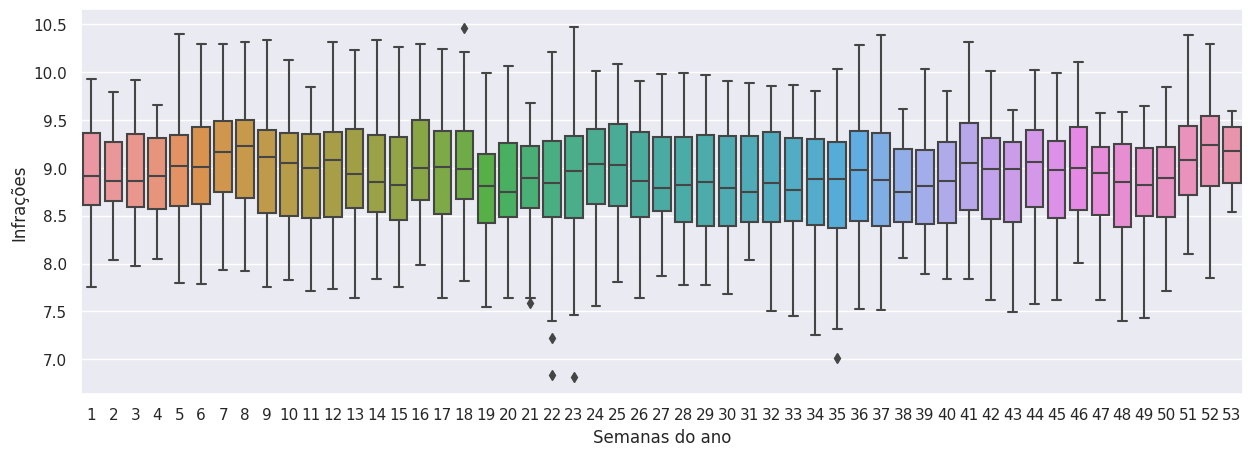

In [148]:
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(
    x= df_2.dat_infracao.dt.week,
    y= df_2['Infrações'],
    ).set(xlabel='Semanas do ano')

[Text(0.5, 0, 'Dias do mês')]

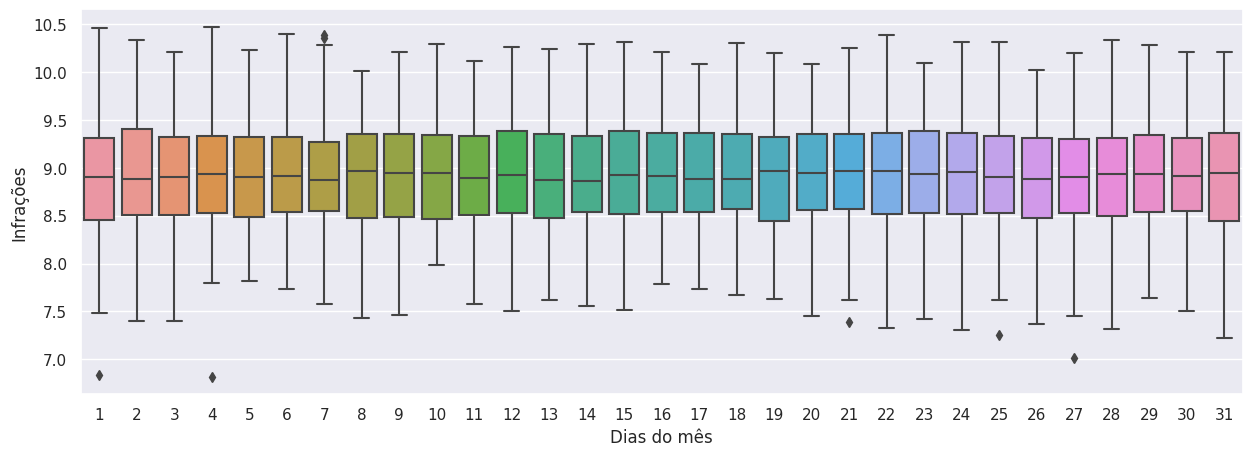

In [150]:
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(
    x= df_2.dat_infracao.dt.day,
    y= df_2['Infrações']
    ).set(xlabel='Dias do mês')

[Text(0.5, 0, 'Anos')]

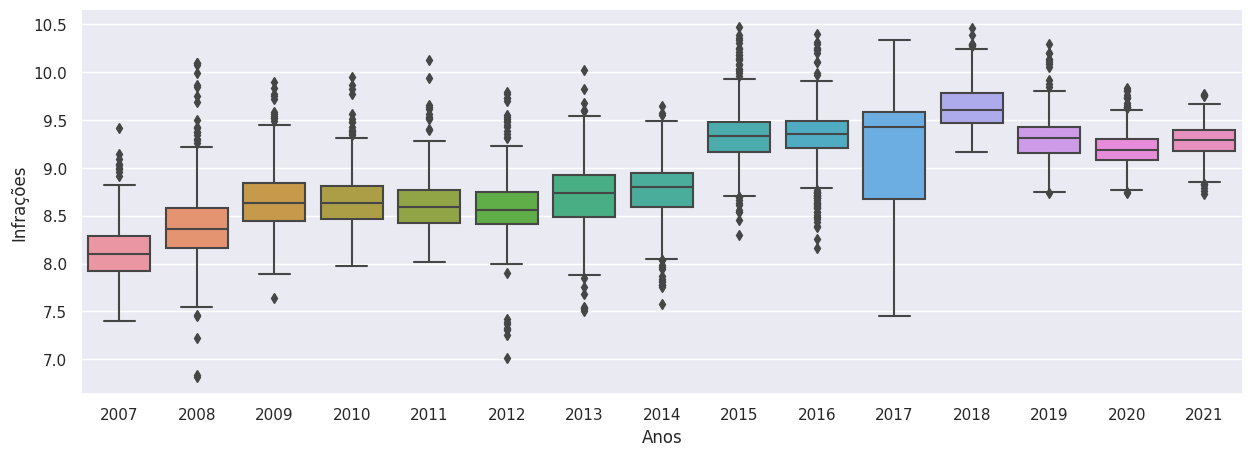

In [152]:
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(
    x= df_2.dat_infracao.dt.year,
    y= df_2['Infrações']
    ).set(xlabel='Anos')

[Text(0.5, 0, 'Anos')]

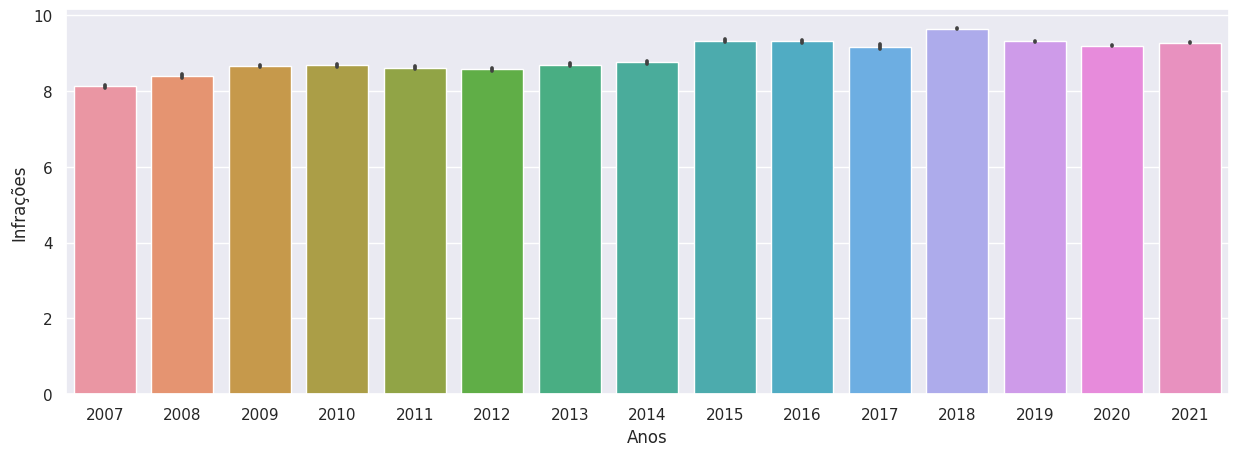

In [153]:
sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(
    x= df_2.dat_infracao.dt.year,
    y= df_2['Infrações']
    ).set(xlabel='Anos')

In [9]:
df_['ocorrencias'] = np.log(df_.uf_infracao)
df_.drop(['med_considerada','uf_infracao'], axis=1, inplace = True)

df_.head()

,ocorrencias
dat_infracao,
2007-01-01,8.008366
2007-01-02,8.250098
2007-01-03,7.756623
2007-01-04,8.331586
2007-01-05,7.922261


In [10]:
mstl = MSTL(
    df_,
    periods=[7, 52, 365],
    windows=[101, 101, 101],
    iterate=3,
    stl_kwargs={
        'trend':1001,
        'seasonal_deg':0
    }
)

res = mstl.fit()

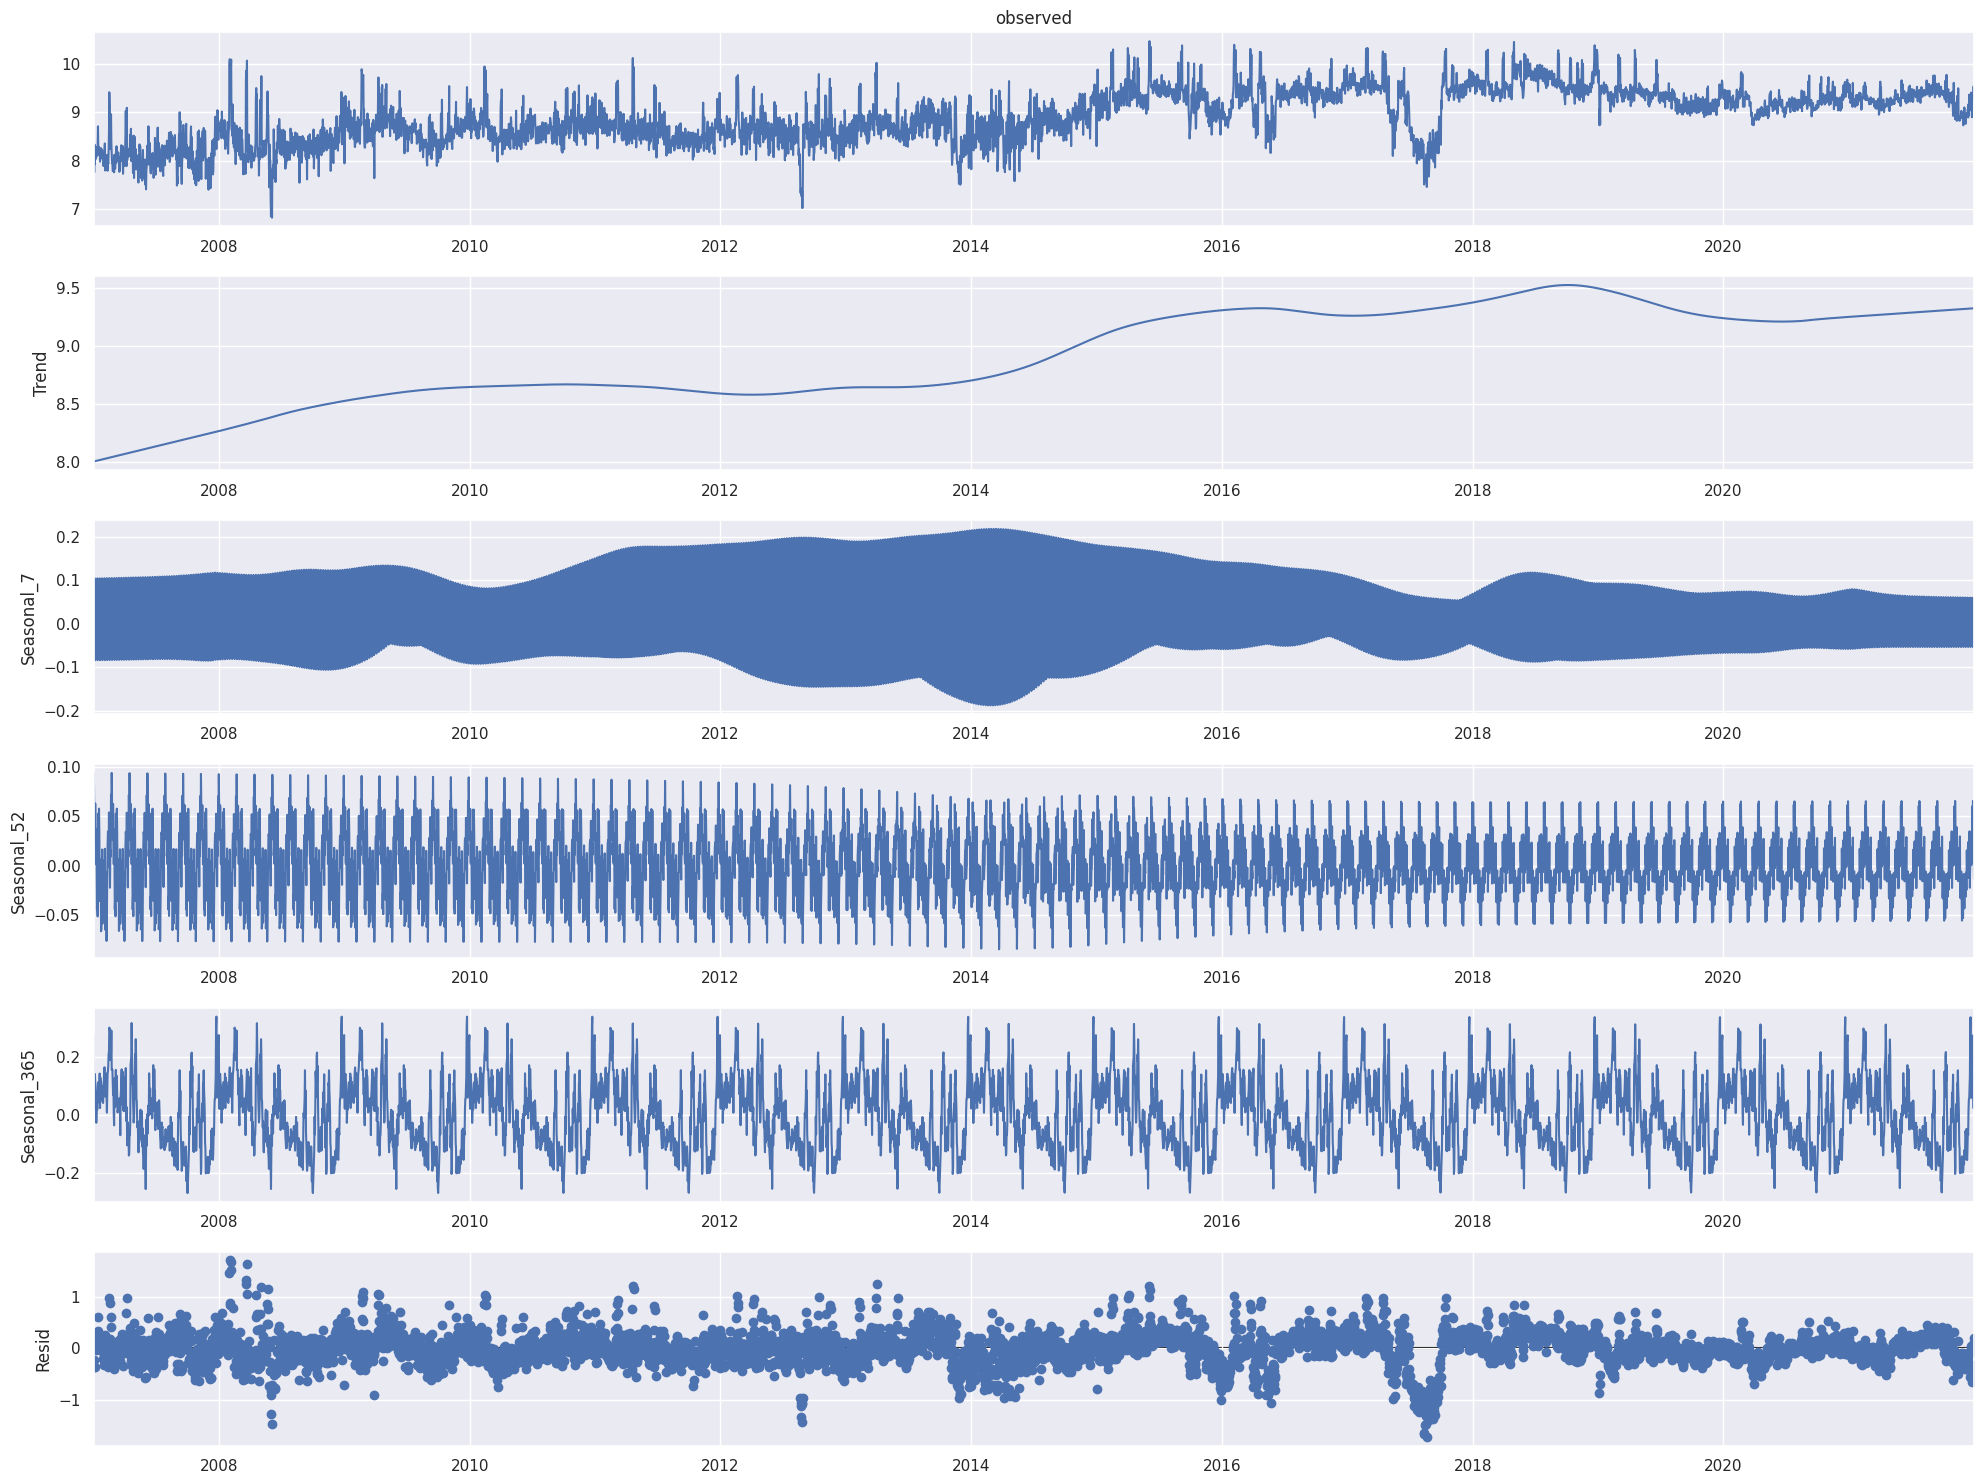

In [11]:
#df_2 = df_.loc['2007-01-01':'2007-12-31']
sns.set(rc={'figure.figsize':(20,15)})
fig = res.plot(observed=True)


In [13]:
result_list = [res.observed, res.trend, res.resid, res.seasonal]
results = pd.concat(result_list, axis=1)

rename = {
    'observed':'Original',
    'trend':'Tendência',
    'seasonal_7':'Intra-semanal',
    'seasonal_52': 'Semanal',
    'seasonal_365': 'Anual',
    'resid':'Resíduo'
    }

results.rename(rename, axis=1, inplace=True)
results.reset_index(inplace=True)


data = results['dat_infracao']
observado = results['Original']
tendencia = results['Tendência']
residuo = results['Resíduo']
diario = results['Intra-semanal']
semanal = results['Semanal']
anual = results['Anual']


<AxesSubplot: xlabel='Resíduo', ylabel='Count'>

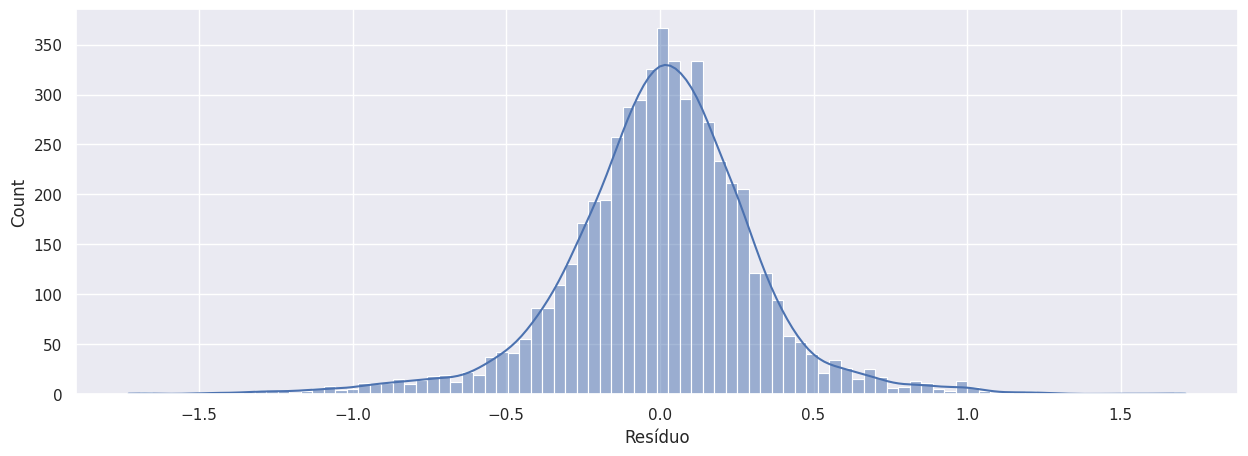

In [54]:
sns.set(rc={'figure.figsize':(15,5)})
sns.histplot(residuo, kde=True)

<AxesSubplot: xlabel='Resíduo', ylabel='Count'>

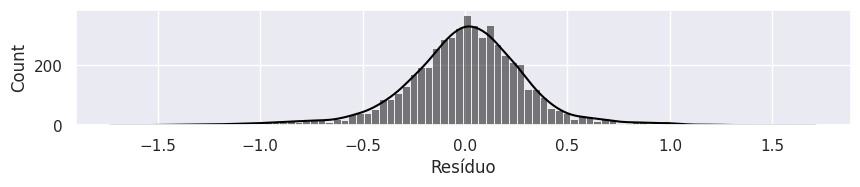

In [55]:
sns.set(rc={'figure.figsize':(10,1.5)})

plots = [observado, tendencia, residuo, diario, semanal, anual]

sns.histplot(residuo, kde=True, alpha=0.5, color='black')

[Text(0.5, 0, '')]

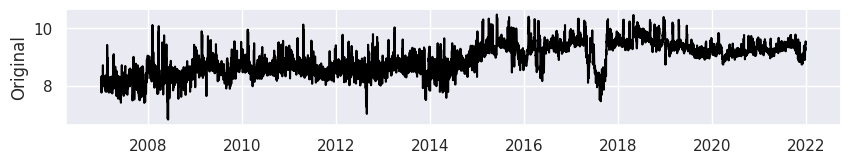

In [56]:
sns.lineplot(observado, alpha=1, color = 'black').set(xlabel=None)

[Text(0.5, 0, '')]

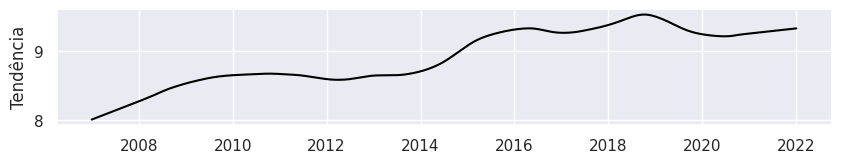

In [57]:
sns.lineplot(tendencia, alpha=1, color = 'black').set(xlabel=None)

[Text(0.5, 0, '')]

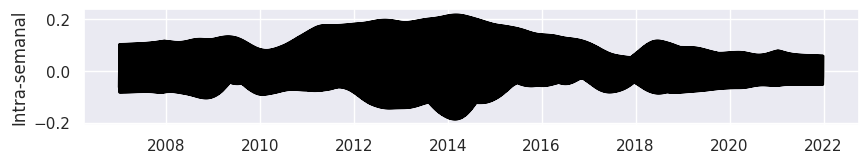

In [58]:
sns.lineplot(diario, alpha=1, color = 'black').set(xlabel=None)

[Text(0.5, 0, '')]

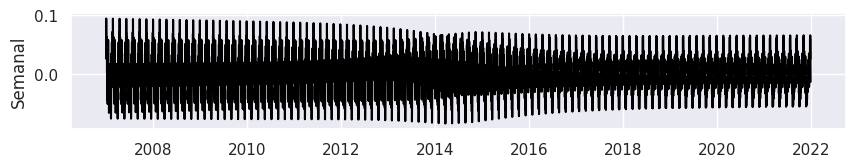

In [59]:
sns.lineplot(semanal, alpha=1, color = 'black').set(xlabel=None)

[Text(0.5, 0, '')]

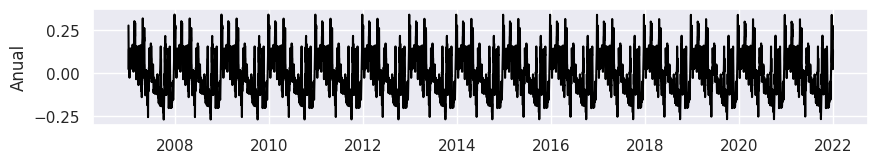

In [60]:
sns.lineplot(anual, alpha=1, color = 'black').set(xlabel=None)

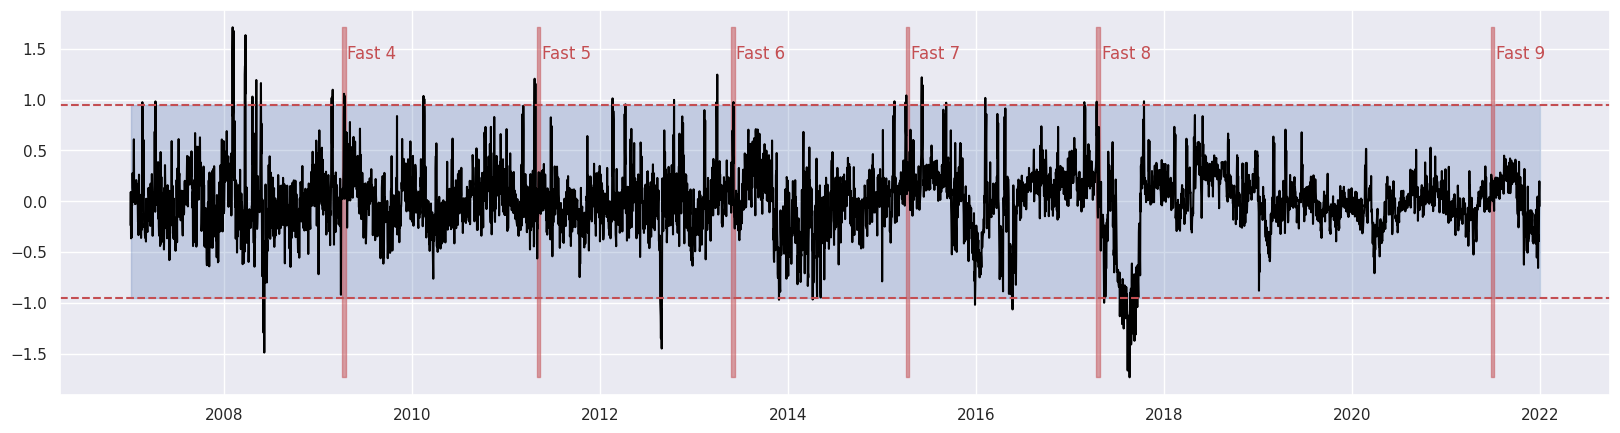

In [46]:
import matplotlib.pyplot as plt 

sns.set(rc={'figure.figsize':(20,5)})

filmes = {
    'Fast 4': '2009-04-03', 
    'Fast 5': '2011-04-29', 
    'Fast 6': '2013-05-24', 
    'Fast 7': '2015-04-02', 
    'Fast 8': '2017-04-13', 
    'Fast 9': '2021-06-24'
    }

x = data
y = residuo
lower = residuo.describe().loc['mean'] - 3 * residuo.describe().loc['std']
upper = residuo.describe().loc['mean'] + 3 * residuo.describe().loc['std']

plt.plot(x,y,color='black')
#plt.xticks(range(2008,2022))
plt.fill_between(
    [pd.Timestamp(data.min()), pd.Timestamp(data.max())], 
    lower, 
    upper, 
    color='b', 
    alpha=0.25
    )
plt.axhline(
    lower, 
    color='r',
    linestyle='dashed')
plt.axhline(
    upper, 
    color='r',
    linestyle='dashed',
    alpha=1)

#plt.text(x=pd.Timestamp('2021-06-01'), y=lower-0.2, s='-3 desvios', color='r')
#plt.text(x=pd.Timestamp('2021-06-01'), y=upper+0.1, s='+3 desvios', color='r')

cir = plt.Circle((0,0),20,color='r')

for filme, ano in filmes.items():
#    plt.axvline(pd.Timestamp(ano), color='r')
    plt.text(pd.Timestamp(ano) + pd.DateOffset(days=20),1.4,s=filme, rotation=0, color='r')
    plt.fill_between(
        [pd.Timestamp(ano), pd.Timestamp(ano) + pd.DateOffset(days=14)],
        residuo.min(),
        residuo.max(),
        color='r',
        alpha=0.50,
        )


plt.show()

,dat_infracao,Original,Tendência,Resíduo,Intra-semanal,Semanal,Anual
0,2007-01-01,8.008366,8.004479,-0.233950,-0.063309,0.026180,0.274965
1,2007-01-02,8.250098,8.005197,0.091718,-0.020004,0.094050,0.079137
2,2007-01-03,7.756623,8.005914,-0.363206,0.033119,0.060759,0.020038
3,2007-01-04,8.331586,8.006632,0.056567,0.074618,0.063040,0.130729
4,2007-01-05,7.922261,8.007349,-0.355983,0.103684,0.026479,0.140731


(-0.2, 1.1)

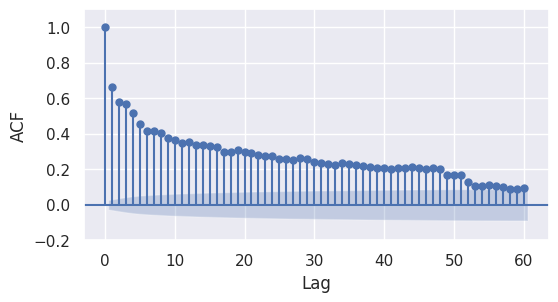

In [119]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

sns.set(rc={'figure.figsize':(6,3)})

filmes = {
    'Fast 4': '2009-04-03', 
    'Fast 5': '2011-04-29', 
    'Fast 6': '2013-05-24', 
    'Fast 7': '2015-04-02', 
    'Fast 8': '2017-04-13', 
    'Fast 9': '2021-06-24'
    }

plot_acf(res.resid, lags=60)

#acf_ = acf(residuo, nlags=2000)

plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('')
plt.ylim([-0.2, 1.1])

(-0.1, 1.1)

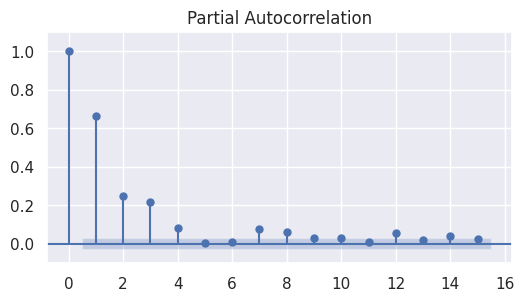

In [95]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(res.resid, lags = 15, method = "ols")
plt.ylim([-0.1, 1.1])

In [128]:
from scipy.stats import moment

print(moment(res.resid, moment=1))



print(moment(res.resid, moment=2))

print('pearson')
print(moment(res.resid, moment=3))

print()

print(moment(res.resid, moment=4))
print('curtose')

print()


0.0
0.09997141663914072
pearson
-0.009699274749816786

0.060958936354776345
curtose



<AxesSubplot: >

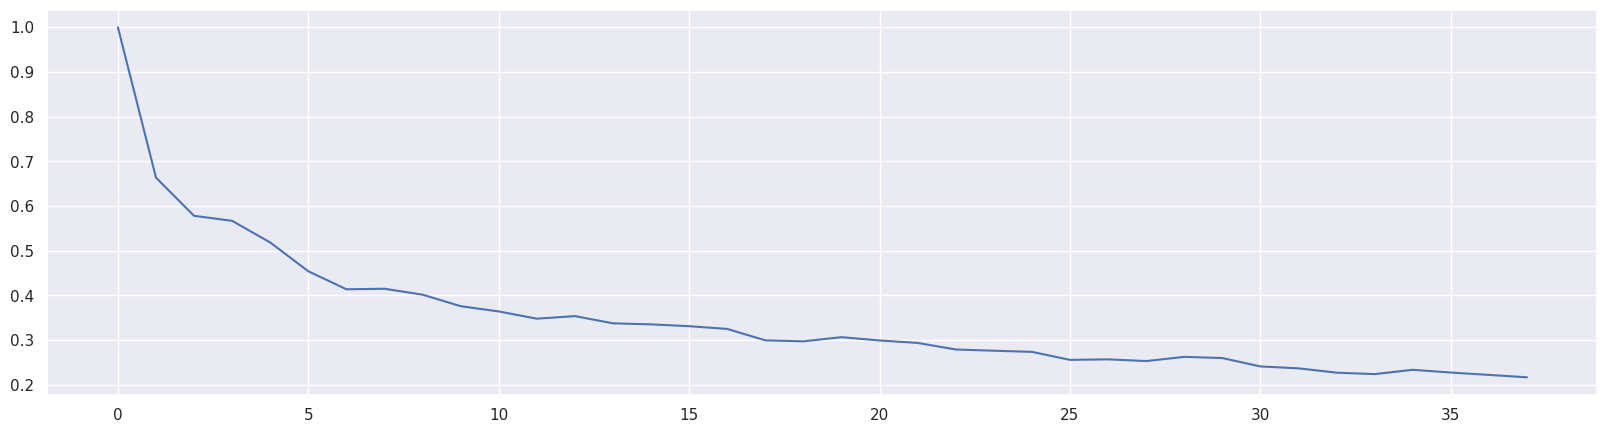

In [53]:
df_2.head()



,dat_infracao,Infrações,med_considerada,Semanas do ano
0,2007-01-01,3006,642,1
1,2007-01-02,3828,1010,1
2,2007-01-03,2337,740,1
3,2007-01-04,4153,2428,1
4,2007-01-05,2758,869,1


#### Plotline (ggplot)

In [62]:
'''

import plotnine
from plotnine import ggplot, aes

filmes = {
    'Fast 4': '2009-04-03', 
    'Fast 5': '2011-04-29', 
    'Fast 6': '2013-05-24', 
    'Fast 7': '2015-04-02', 
    'Fast 8': '2017-04-13', 
    'Fast 9': '2021-06-24'
    }

filme = list(filmes.keys())
ano = list(filmes.values())

plotnine.options.figure_size = (15,5)


ggpl_line = ggplot(data=results, mapping=aes(x='dat_infracao', y='Resíduo'))
lineplot = (ggpl_line + 
plotnine.geom_line(color='black') + 
plotnine.labs(title='Resíduos')
# + plotnine.annotate('text', x=pd.Timestamp(ano[0]), y=4235, label=filme[0], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[1]), y=4235, label=filme[1], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[2]), y=4235, label=filme[2], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[3]), y=4235, label=filme[3], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[4]), y=4235, label=filme[4], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[5]), y=4235, label=filme[5], color='red')
).draw()

residuo_ = pd.DataFrame()
residuo_['Resíduo'] = (residuo - residuo.describe().mean() )/ residuo.describe().std()
residuo_.describe()

ggpl_hist = ggplot(residuo_, mapping=aes(x='Resíduo'))

histplot = (ggpl_hist 
            + plotnine.geom_histogram(fill='pink') 
            + plotnine.geom_density(alpha = 0.25)
            ).draw()



ggpl_line = ggplot(data=resuacf_lts, mapping=aes(x='dat_infracao', y='Resíduo'))
lineplot = (ggpl_line + 
plotnine.geom_line(color='black') + 
plotnine.labs(title='Resíduos')
# + plotnine.annotate('text', x=pd.Timestamp(ano[0]), y=4235, label=filme[0], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[1]), y=4235, label=filme[1], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[2]), y=4235, label=filme[2], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[3]), y=4235, label=filme[3], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[4]), y=4235, label=filme[4], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[5]), y=4235, label=filme[5], color='red')
).draw()
'''

pass

In [63]:
df_.ocorrencias.describe()

count    5479.000000
mean        8.918040
std         0.538454
min         6.817831
25%         8.509766
50%         8.921725
75%         9.344915
max        10.473619
Name: ocorrencias, dtype: float64

<AxesSubplot: xlabel='dat_infracao'>

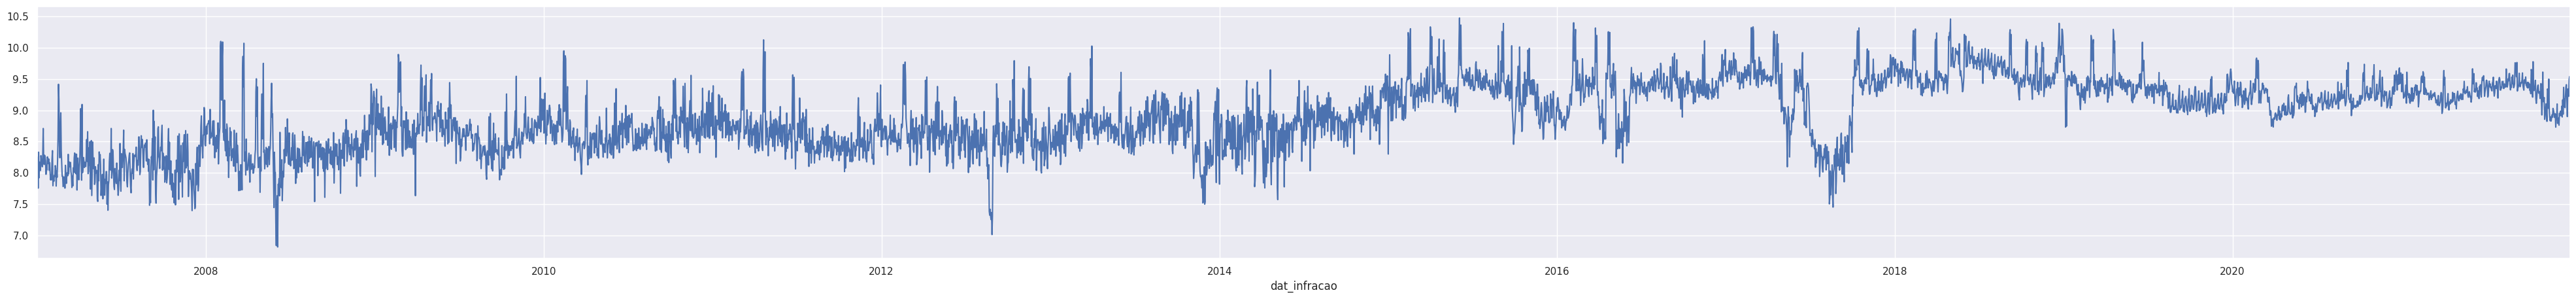

In [64]:
df_.ocorrencias.plot()

In [65]:
import statsmodels.api as sm

decomp = sm.tsa.seasonal_decompose(df_['ocorrencias'], model='multiplicative', period=30)

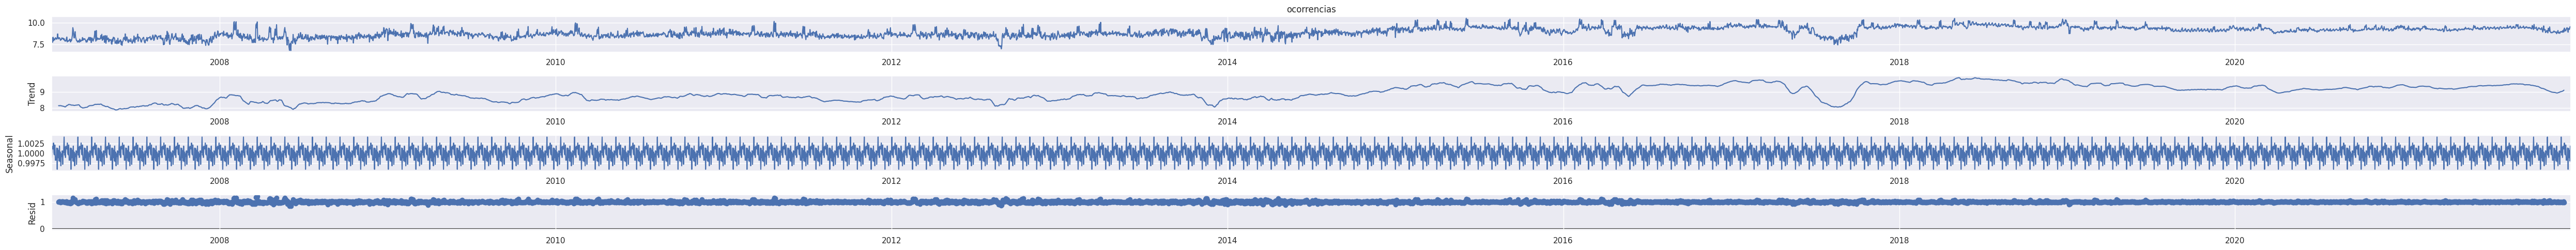

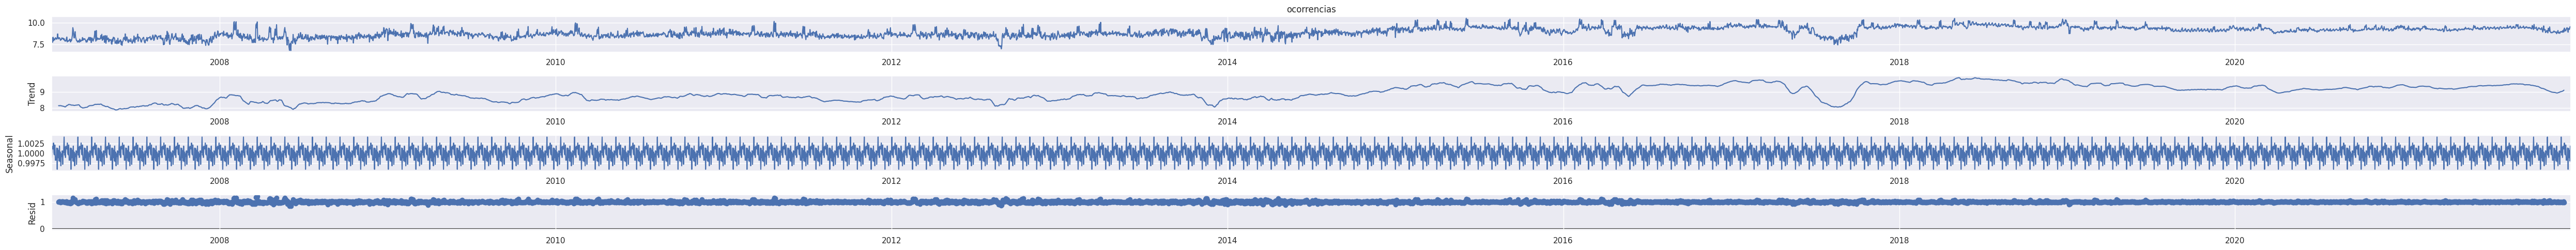

In [66]:
decomp.plot()

In [67]:
sns.histplot(
    df_.count,
    kde=True)

TypeError: object of type 'method' has no len()

In [ ]:
frame.head().columns

In [ ]:
lista = list(df.descricao_abreviada.unique())
lista.sort()

lista